In [3]:
import os
import string
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# 1. Drive Bağlantısı
drive.mount('/content/drive')

# 2. Yolları Tanımlama
ANA_KLASOR = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data'
RESIM_KLASORU = os.path.join(ANA_KLASOR, 'Images')
CAPTION_DOSYASI = os.path.join(ANA_KLASOR, 'captions.txt')
OZELLIK_DOSYASI = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/features.pkl'

print(f"Ana Klasör: {ANA_KLASOR}")
print(f"Resimler: {RESIM_KLASORU}")
print(f"Metin Dosyası: {CAPTION_DOSYASI}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ana Klasör: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data
Resimler: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data/Images
Metin Dosyası: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/Flickr8k_Data/captions.txt


In [4]:
def verileri_yukle_ve_temizle(filename):
    with open(filename, 'r') as file:
        text = file.read()

    mapping = {}
    ham_veri_ornekleri = {} # Rapor için ham hallerini saklayalım
    satirlar = text.split('\n')
    satirlar = satirlar[1:] # Başlığı atla

    table = str.maketrans('', '', string.punctuation)

    for satir in satirlar:
        tokens = satir.split(',')
        if len(tokens) < 2: continue

        # ID'den .jpg uzantısını atalım ki VGG çıktılarıyla eşleşsin
        image_id = tokens[0].split('.')[0]
        caption_raw = " ".join(tokens[1:]) # Ham hali

        # --- TEMİZLİK ---
        caption = caption_raw.lower()
        caption = caption.translate(table)
        caption = caption.split()
        caption = [word for word in caption if len(word) > 1]
        caption = [word for word in caption if word.isalpha()]

        # Token Ekleme
        caption_clean = 'startseq ' + ' '.join(caption) + ' endseq'

        # Sözlüğe ekle
        if image_id not in mapping:
            mapping[image_id] = []
            ham_veri_ornekleri[image_id] = [] # Rapor için

        mapping[image_id].append(caption_clean)
        ham_veri_ornekleri[image_id].append(caption_raw) # Rapor için ham hali

    return mapping, ham_veri_ornekleri


print("Metinler işleniyor...")
mapping, ham_veriler = verileri_yukle_ve_temizle(CAPTION_DOSYASI)
print(f"Toplam İşlenen Resim Sayısı: {len(mapping)}")

Metinler işleniyor...
Toplam İşlenen Resim Sayısı: 8091


In [5]:
# Eğer features.pkl zaten varsa yükle, yoksa VGG16 ile çıkar
if os.path.exists(OZELLIK_DOSYASI):
    print("Özellik dosyası bulundu! Tekrar işlem yapmaya gerek yok.")
    print("Dosyadan yükleniyor...")
    with open(OZELLIK_DOSYASI, 'rb') as f:
        features = pickle.load(f)
    print("Yüklendi!")
else:
    print("Özellik dosyası bulunamadı. VGG16 ile çıkarılıyor (Bu işlem zaman alabilir)...")

    # Modeli Kur
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    features = {}
    directory = os.listdir(RESIM_KLASORU)

    for img_name in tqdm(directory):
        if not img_name.endswith('.jpg'): continue

        # ID Hazırla
        image_id = img_name.split('.')[0]

        # Resim Yükle ve İşle
        img_path = os.path.join(RESIM_KLASORU, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        # Tahmin (Extract)
        feature = model.predict(image, verbose=0)
        features[image_id] = feature

    # Kaydet
    with open(OZELLIK_DOSYASI, 'wb') as f:
        pickle.dump(features, f)
    print(f"Özellikler kaydedildi: {OZELLIK_DOSYASI}")

print(f"Özellikleri çıkarılan toplam resim: {len(features)}")

Özellik dosyası bulundu! Tekrar işlem yapmaya gerek yok.
Dosyadan yükleniyor...
Yüklendi!
Özellikleri çıkarılan toplam resim: 8091


--- RAPOR İÇİN ÖRNEK VERİ ANALİZİ (ID: 1110208841_5bb6806afe) ---


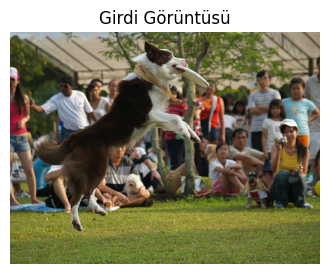


Adım 1: Metin Ön İşleme (Preprocessing)
HAM CÜMLE (Raw)                                              | İŞLENMİŞ CÜMLE (Processed)
----------------------------------------------------------------------------------------------------
A black and white Border Collie catches a Frisbee in front   | startseq black and white border collie catches frisbee in front of an audience endseq
a brown and white dog catches a Frisbee in it mouth in fro   | startseq brown and white dog catches frisbee in it mouth in front of group of people endseq

Adım 2: Görüntü Özellik Çıkarımı (Feature Extraction - CNN)
Görüntü VGG16 modelinden geçirildi ve aşağıdaki vektöre dönüştürüldü:
Vektör Boyutu: (1, 4096)
Vektör Örneği (İlk 20 sayı): [0.         0.         1.0149103  0.         0.         0.
 0.         1.9113584  0.         4.0964537  0.         0.
 0.         0.         0.         0.         0.         0.07782921
 1.2445879  0.        ]
...


In [6]:
# --- RAPOR İÇİN GÖRSELLEŞTİRME ---
# Rastgele bir ID seçelim
ornek_id = list(mapping.keys())[100] # 100. resmi örnek alalım
img_path = os.path.join(RESIM_KLASORU, ornek_id + '.jpg')

print(f"--- RAPOR İÇİN ÖRNEK VERİ ANALİZİ (ID: {ornek_id}) ---")

# 1. Resmi Göster
plt.figure(figsize=(4,4))
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Girdi Görüntüsü")
plt.show()

# 2. Metin Dönüşümü Tablosu
print("\nAdım 1: Metin Ön İşleme (Preprocessing)")
print(f"{'HAM CÜMLE (Raw)':<60} | {'İŞLENMİŞ CÜMLE (Processed)'}")
print("-" * 100)
for ham, temiz in zip(ham_veriler[ornek_id][:2], mapping[ornek_id][:2]):
    print(f"{ham[:58]:<60} | {temiz}")

# 3. Vektör Dönüşümü
print("\nAdım 2: Görüntü Özellik Çıkarımı (Feature Extraction - CNN)")
print("Görüntü VGG16 modelinden geçirildi ve aşağıdaki vektöre dönüştürüldü:")
print(f"Vektör Boyutu: {features[ornek_id].shape}")
print(f"Vektör Örneği (İlk 20 sayı): {features[ornek_id][0][:20]}")
print("...")

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# 1. Tüm cümleleri tek bir listede toplayalım
tum_cumleler = []
for key in mapping.keys():
    for caption in mapping[key]:
        tum_cumleler.append(caption)

# 2. Tokenizer'ı Eğitelim (Kelime -> Sayı eşleştirmesi)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tum_cumleler)

# Kelime Dağarcığı Boyutu (Model için çok önemli)
# +1 ekliyoruz çünkü 0 indeksi "padding" (boşluk doldurma) için ayrılır.
vocab_size = len(tokenizer.word_index) + 1

# En uzun cümleyi bulalım (Tüm cümleleri buna göre sabitleyeceğiz)
max_length = max(len(caption.split()) for caption in tum_cumleler)

print(f"Kelime Dağarcığı (Vocab Size): {vocab_size}")
print(f"En Uzun Cümle (Max Length): {max_length} kelime")

# 3. Tokenizer'ı da Kaydedelim (İleride test yaparken lazım olacak)
tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer kaydedildi: {tokenizer_path}")

print("-" * 30)

# 4. EĞİTİM VE TEST AYIRMA (TRAIN - TEST SPLIT)
# Resim ID'lerini bir listeye alalım
tum_resim_idleri = list(mapping.keys())

# Karıştıralım ki rastgele olsun (Sıralı olmasın)
np.random.shuffle(tum_resim_idleri)

# %90 Eğitim, %10 Test oranı belirleyelim
bolme_noktasi = int(len(tum_resim_idleri) * 0.90) # %90 yapalım, veri çok olsun, %10 test yeterli.

train_ids = tum_resim_idleri[:bolme_noktasi]
test_ids = tum_resim_idleri[bolme_noktasi:]

print(f"Toplam Resim Sayısı: {len(tum_resim_idleri)}")
print(f"Eğitim (Train) Seti : {len(train_ids)} resim")
print(f"Test (Sınav) Seti   : {len(test_ids)} resim")

Kelime Dağarcığı (Vocab Size): 8766
En Uzun Cümle (Max Length): 34 kelime
Tokenizer kaydedildi: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/tokenizer.pkl
------------------------------
Toplam Resim Sayısı: 8091
Eğitim (Train) Seti : 7281 resim
Test (Sınav) Seti   : 810 resim


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Metin_Girdisi       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Goruntu_Girdisi     │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,096 │ Metin_Girdisi[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ Goruntu_Girdisi[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ Metin_Girdisi[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Cikis (Dense)       │ (None, 8766)      │  2,252,862 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

None


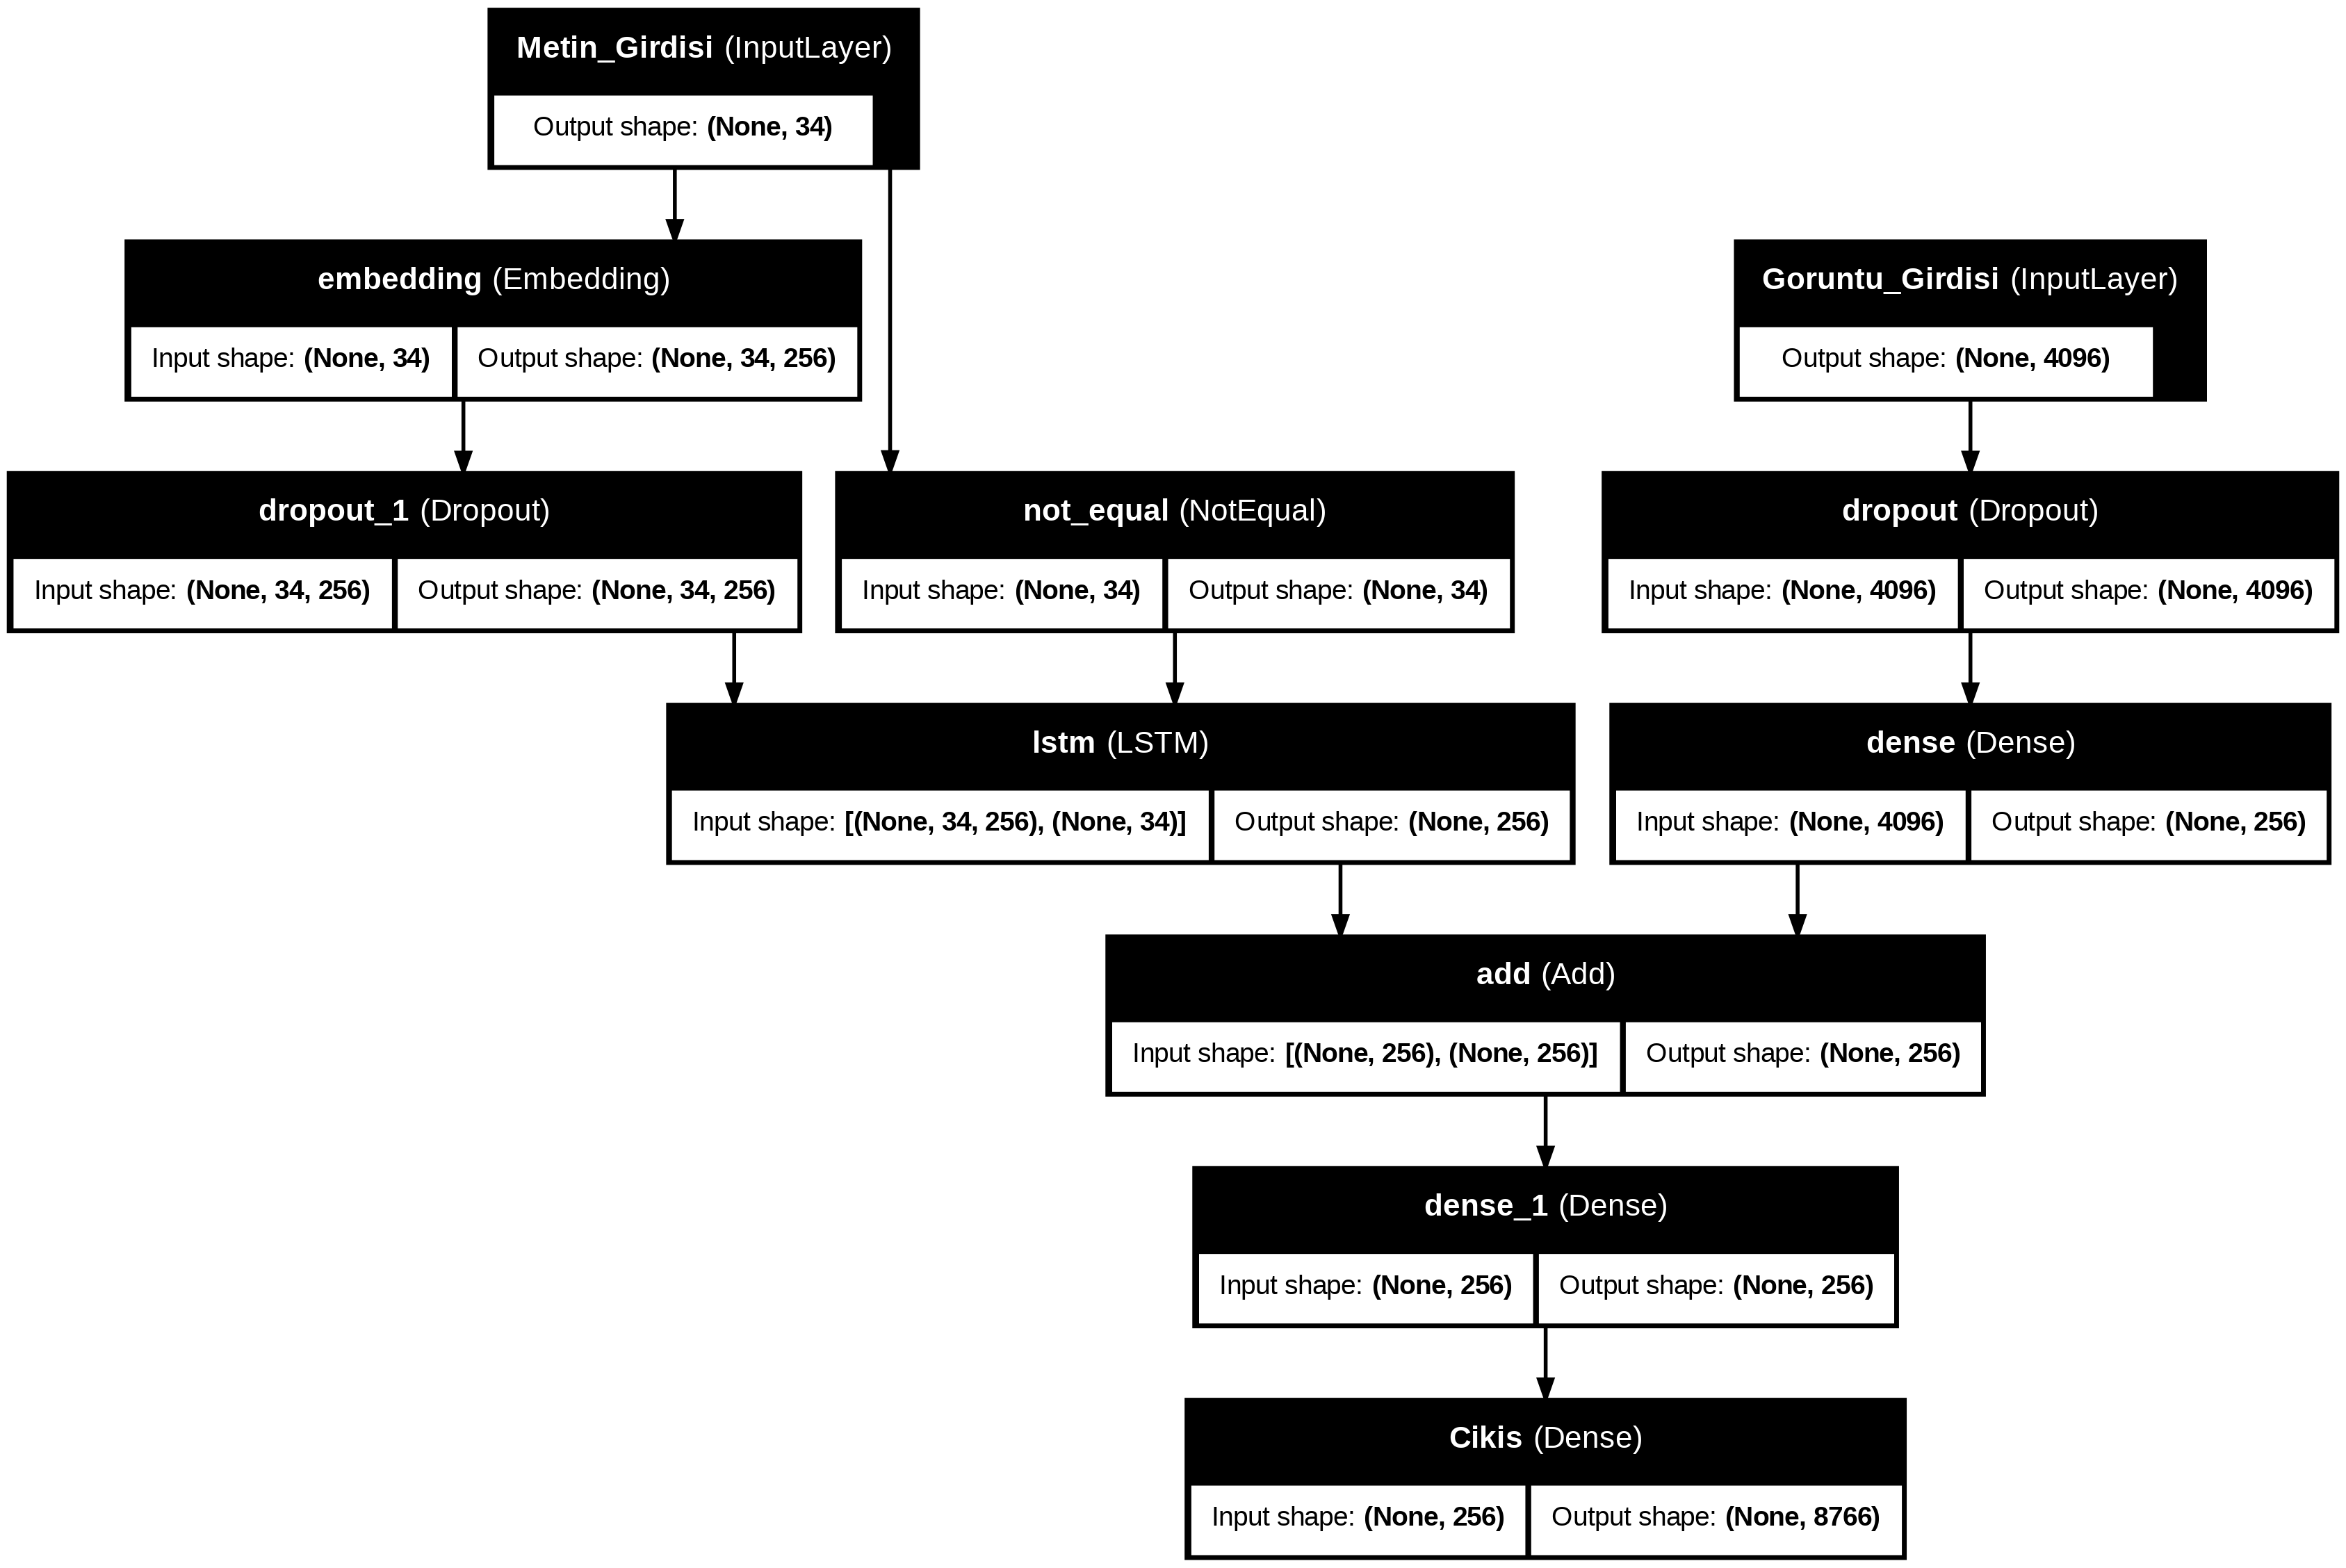

In [8]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# --- PARAMETRELER (Senin çıktılarından aldım) ---
vocab_size = 8766     # Kelime dağarcığı
max_length = 34       # Maksimum cümle uzunluğu
embedding_dim = 256   # Kelimelerin vektör büyüklüğü (Standarttır)
units = 256           # LSTM ve Dense katmanlarının nöron sayısı

# --- 1. KOL: GÖRÜNTÜ İŞLEME (Feature Extractor) ---
inputs1 = Input(shape=(4096,), name="Goruntu_Girdisi")
fe1 = Dropout(0.5)(inputs1) # Overfitting engellemek için %50'sini kapat
fe2 = Dense(units, activation='relu')(fe1) # 4096'yı 256'ya sıkıştır

# --- 2. KOL: METİN İŞLEME (Sequence Processor) ---
inputs2 = Input(shape=(max_length,), name="Metin_Girdisi")
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # Kelime -> Vektör
se2 = Dropout(0.5)(se1)
se3 = LSTM(units)(se2) # İşte LSTM burada!

# --- 3. BİRLEŞTİRME (Decoder) ---
decoder1 = add([fe2, se3]) # Görüntü ve Yazı bilgisini topla
decoder2 = Dense(units, activation='relu')(decoder1)

# --- ÇIKIŞ KATMANI ---
# Vocab size kadar çıkış veriyoruz, çünkü her kelime için bir olasılık hesaplayacak
outputs = Dense(vocab_size, activation='softmax', name="Cikis")(decoder2)

# Modeli oluştur
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Modeli derle (Compile)
# loss='categorical_crossentropy': Çünkü çok sınıflı (8766 kelime) bir sınıflandırma yapıyoruz.
# optimizer='adam': En popüler ve hızlı optimize edici.
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Model Özetini Yazdır
print(model.summary())

# --- RAPOR İÇİN ŞEMA ÇİZDİRME ---
# Bu resmi raporunun "Model Mimarisi" bölümüne koyacaksın. Harika durur.
plot_model(model, to_file='model_semasi.png', show_shapes=True, show_layer_names=True)

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import os

# --- AYARLAR ---
FINAL_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/final_model.h5'
CHECKPOINT_PATH = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/best_model.h5'

# Eğer model zaten varsa eğitimi pas geçmek için FALSE yap.
# Modeli silip baştan zorla eğitmek istersen burayı TRUE yap.
TEKRAR_EGIT = False

# --- KONTROL MEKANİZMASI ---
if os.path.exists(FINAL_MODEL_PATH) and not TEKRAR_EGIT:
    print("✅ Model dosyası zaten bulundu!")
    print(f"Yol: {FINAL_MODEL_PATH}")
    print("Eğitim atlanıyor... Mevcut ağırlıklar yükleniyor.")

    # DÜZELTME BURADA: load_model yerine load_weights kullanıyoruz.
    # Çünkü modelin iskeleti zaten hafızada var (Bir önceki hücrede kurduk).
    model.load_weights(FINAL_MODEL_PATH)
    print("✅ Ağırlıklar başarıyla yüklendi.")

else:
    print("🚀 Model bulunamadı veya TEKRAR_EGIT=True seçildi. Eğitim başlıyor...")

    # --- 1. VERİ ÜRETECİ FONKSİYONU ---
    def data_generator_func(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
        X1, X2, y = list(), list(), list()
        n = 0
        while True:
            for key in data_keys:
                n += 1
                feature = features[key][0]
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)

                if n == batch_size:
                    yield ((np.array(X1), np.array(X2)), np.array(y))
                    X1, X2, y = list(), list(), list()
                    n = 0

    # --- 2. TENSORFLOW DATASET OLUŞTURMA ---
    output_signature = (
        (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )

    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_func(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )

    train_dataset = train_dataset.repeat()

    # --- 3. EĞİTİM AYARLARI ---
    epochs = 20
    batch_size = 32
    steps = len(train_ids) // batch_size

    checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='loss', verbose=1, save_best_only=True, mode='min')

    # --- 4. EĞİTİMİ BAŞLAT ---
    print(f"Toplam {epochs} Epoch sürecek...")
    print("-" * 50)

    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps,
        verbose=1,
        callbacks=[checkpoint]
    )

    # Kaydet (Weights olarak kaydetmek daha güvenli ama şimdilik formatı bozmuyoruz)
    model.save(FINAL_MODEL_PATH)
    print(f"\nEğitim Tamamlandı! Model kaydedildi: {FINAL_MODEL_PATH}")

✅ Model dosyası zaten bulundu!
Yol: /content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje/final_model.h5
Eğitim atlanıyor... Mevcut ağırlıklar yükleniyor.
✅ Ağırlıklar başarıyla yüklendi.


In [14]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

# --- AKILLI GRAFİK ÇİZCİ ---

# SENARYO 1: Eğitim bu oturumda yapıldı (history değişkeni dolu)
if 'history' in locals() and history is not None:
    print("📊 Yeni eğitim verileri bulundu, grafik çiziliyor...")

    # Verileri al
    loss_degerleri = history.history['loss']
    epoch_sayilari = range(1, len(loss_degerleri) + 1)

    # Çiz
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_sayilari, loss_degerleri, 'b-o', label='Eğitim Hatası (Training Loss)')
    plt.title('Model Eğitim Süreci (Loss Grafiği)')
    plt.xlabel('Epoch (Tur Sayısı)')
    plt.ylabel('Loss (Hata Oranı)')
    plt.legend()
    plt.grid(True)

    # Grafiği kaydet (ki sonraki seferler için dursun)
    plt.savefig('loss_grafigi.png')
    plt.show()
    print("✅ Grafik başarıyla çizildi ve 'loss_grafigi.png' olarak kaydedildi.")

# SENARYO 2: Eğitim atlandı ama daha önceden kaydedilmiş grafik resmi var
elif os.path.exists('loss_grafigi.png'):
    print("ℹ️ Eğitim bu oturumda atlandı (hazır model yüklendi).")
    print("📂 Daha önce kaydedilmiş grafik gösteriliyor:")

    img = mpimg.imread('loss_grafigi.png')
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off') # Çerçeveyi gizle
    plt.show()

# SENARYO 3: Ne eğitim var ne de kayıtlı resim
else:
    print("ℹ️ Eğitim yapılmadığı için anlık grafik verisi yok.")
    print("Eğer sıfırdan eğitim yaparsanız grafik burada otomatik oluşacaktır.")

ℹ️ Eğitim yapılmadığı için anlık grafik verisi yok.
Eğer sıfırdan eğitim yaparsanız grafik burada otomatik oluşacaktır.


Test setinden rastgele resimler seçiliyor...


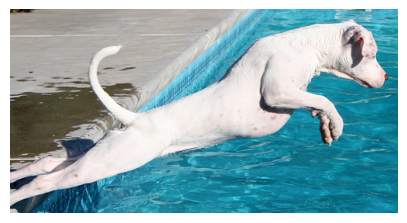


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq white dog is leaping into swimming pool endseq
YAPAY ZEKA TAHMİNİ: white dog is jumping into the water
------------------------------------------------



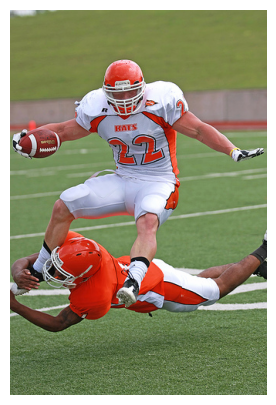


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq football player in possession of the ball gets tackled by football player on the opposing team endseq
YAPAY ZEKA TAHMİNİ: two football players playing soccer
------------------------------------------------



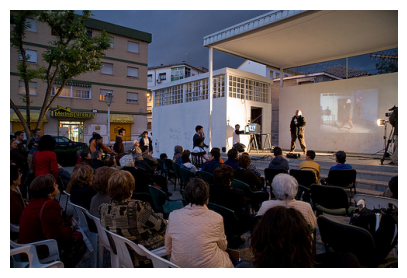


------------------------------------------------
GERÇEK AÇIKLAMA (İnsandan): startseq lone performer or lecturer takes the stage in an urban setting for crowd of about spectators endseq
YAPAY ZEKA TAHMİNİ: crowd of people are standing in line presentation
------------------------------------------------



In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# --- YARDIMCI FONKSİYONLAR ---
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    # startseq ve endseq kelimelerini temizleyelim ki cümle güzel görünsün
    final_cumle = in_text.replace('startseq ', '').replace(' endseq', '')
    return final_cumle

# --- TEST İŞLEMİ ---
print("Test setinden rastgele resimler seçiliyor...")

# Test için ayırdığımız 'test_ids' listesinden rastgele 3 tane seç
import random
random_test_ids = random.sample(test_ids, 3)

for image_id in random_test_ids:
    # 1. Resmi Bul ve Göster
    img_path = os.path.join(RESIM_KLASORU, image_id + '.jpg')
    img = plt.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 2. Resmin Özelliğini Al (Features sözlüğünden)
    # Model eğitimi sırasında özellikleri zaten çıkarmıştık, tekrar VGG'ye sokmaya gerek yok
    feature = features[image_id]

    # 3. Yorum Yaptır
    yorum = generate_desc(model, tokenizer, feature, max_length)

    print("\n------------------------------------------------")
    print(f"GERÇEK AÇIKLAMA (İnsandan): {mapping[image_id][0]}") # İlk gerçek cümleyi göster
    print(f"YAPAY ZEKA TAHMİNİ: \033[1m{yorum}\033[0m") # Kalın fontla yaz
    print("------------------------------------------------\n")